# Building a image classification Neural Network

### Jack Edney

Despite having good knowledge and understanding of the concept and practice of how neural networks can classify images, and decent Python skills, this will be my first attempt to build my very own neural network.

Starting off, I need to determine what kind of image classification, I intend to do. I will begin with deciding on two categories of image, and train the neural network to choose between these two classifications and as binary classifications can reproduce false classifications for instances that satisfy neither category, I will also implement a NULL output.

After careful consideration, I have decided that the classification will involve cars. These are usually well photographed, they are easily classified by the human brain and there are large numbers of photographs of them online.

The training data, according to a few online [sources](https://petewarden.com/2017/12/14/how-many-images-do-you-need-to-train-a-neural-network/) should number around 1000 per class, although it is well known that the more data you have, the better your model is at learning.

My three outputs for the neural network will be, 
* the probability that the car in the input is my favourite car
* the probability that the car in the input is my girlfriend's favourite car
* the probability that the car in the input is neither my favourite or my girlfriend's favourite car

So, I will need 1000 images of my favourite car (which is a Honda S2000), 1000 images of my girlfriend's favourite car (which is a Porsche 911) and I want at least 2000 images of cars that are neither a Honda S2000 or a Porsche 911, to be safe.

Here an example image of the Honda S2000: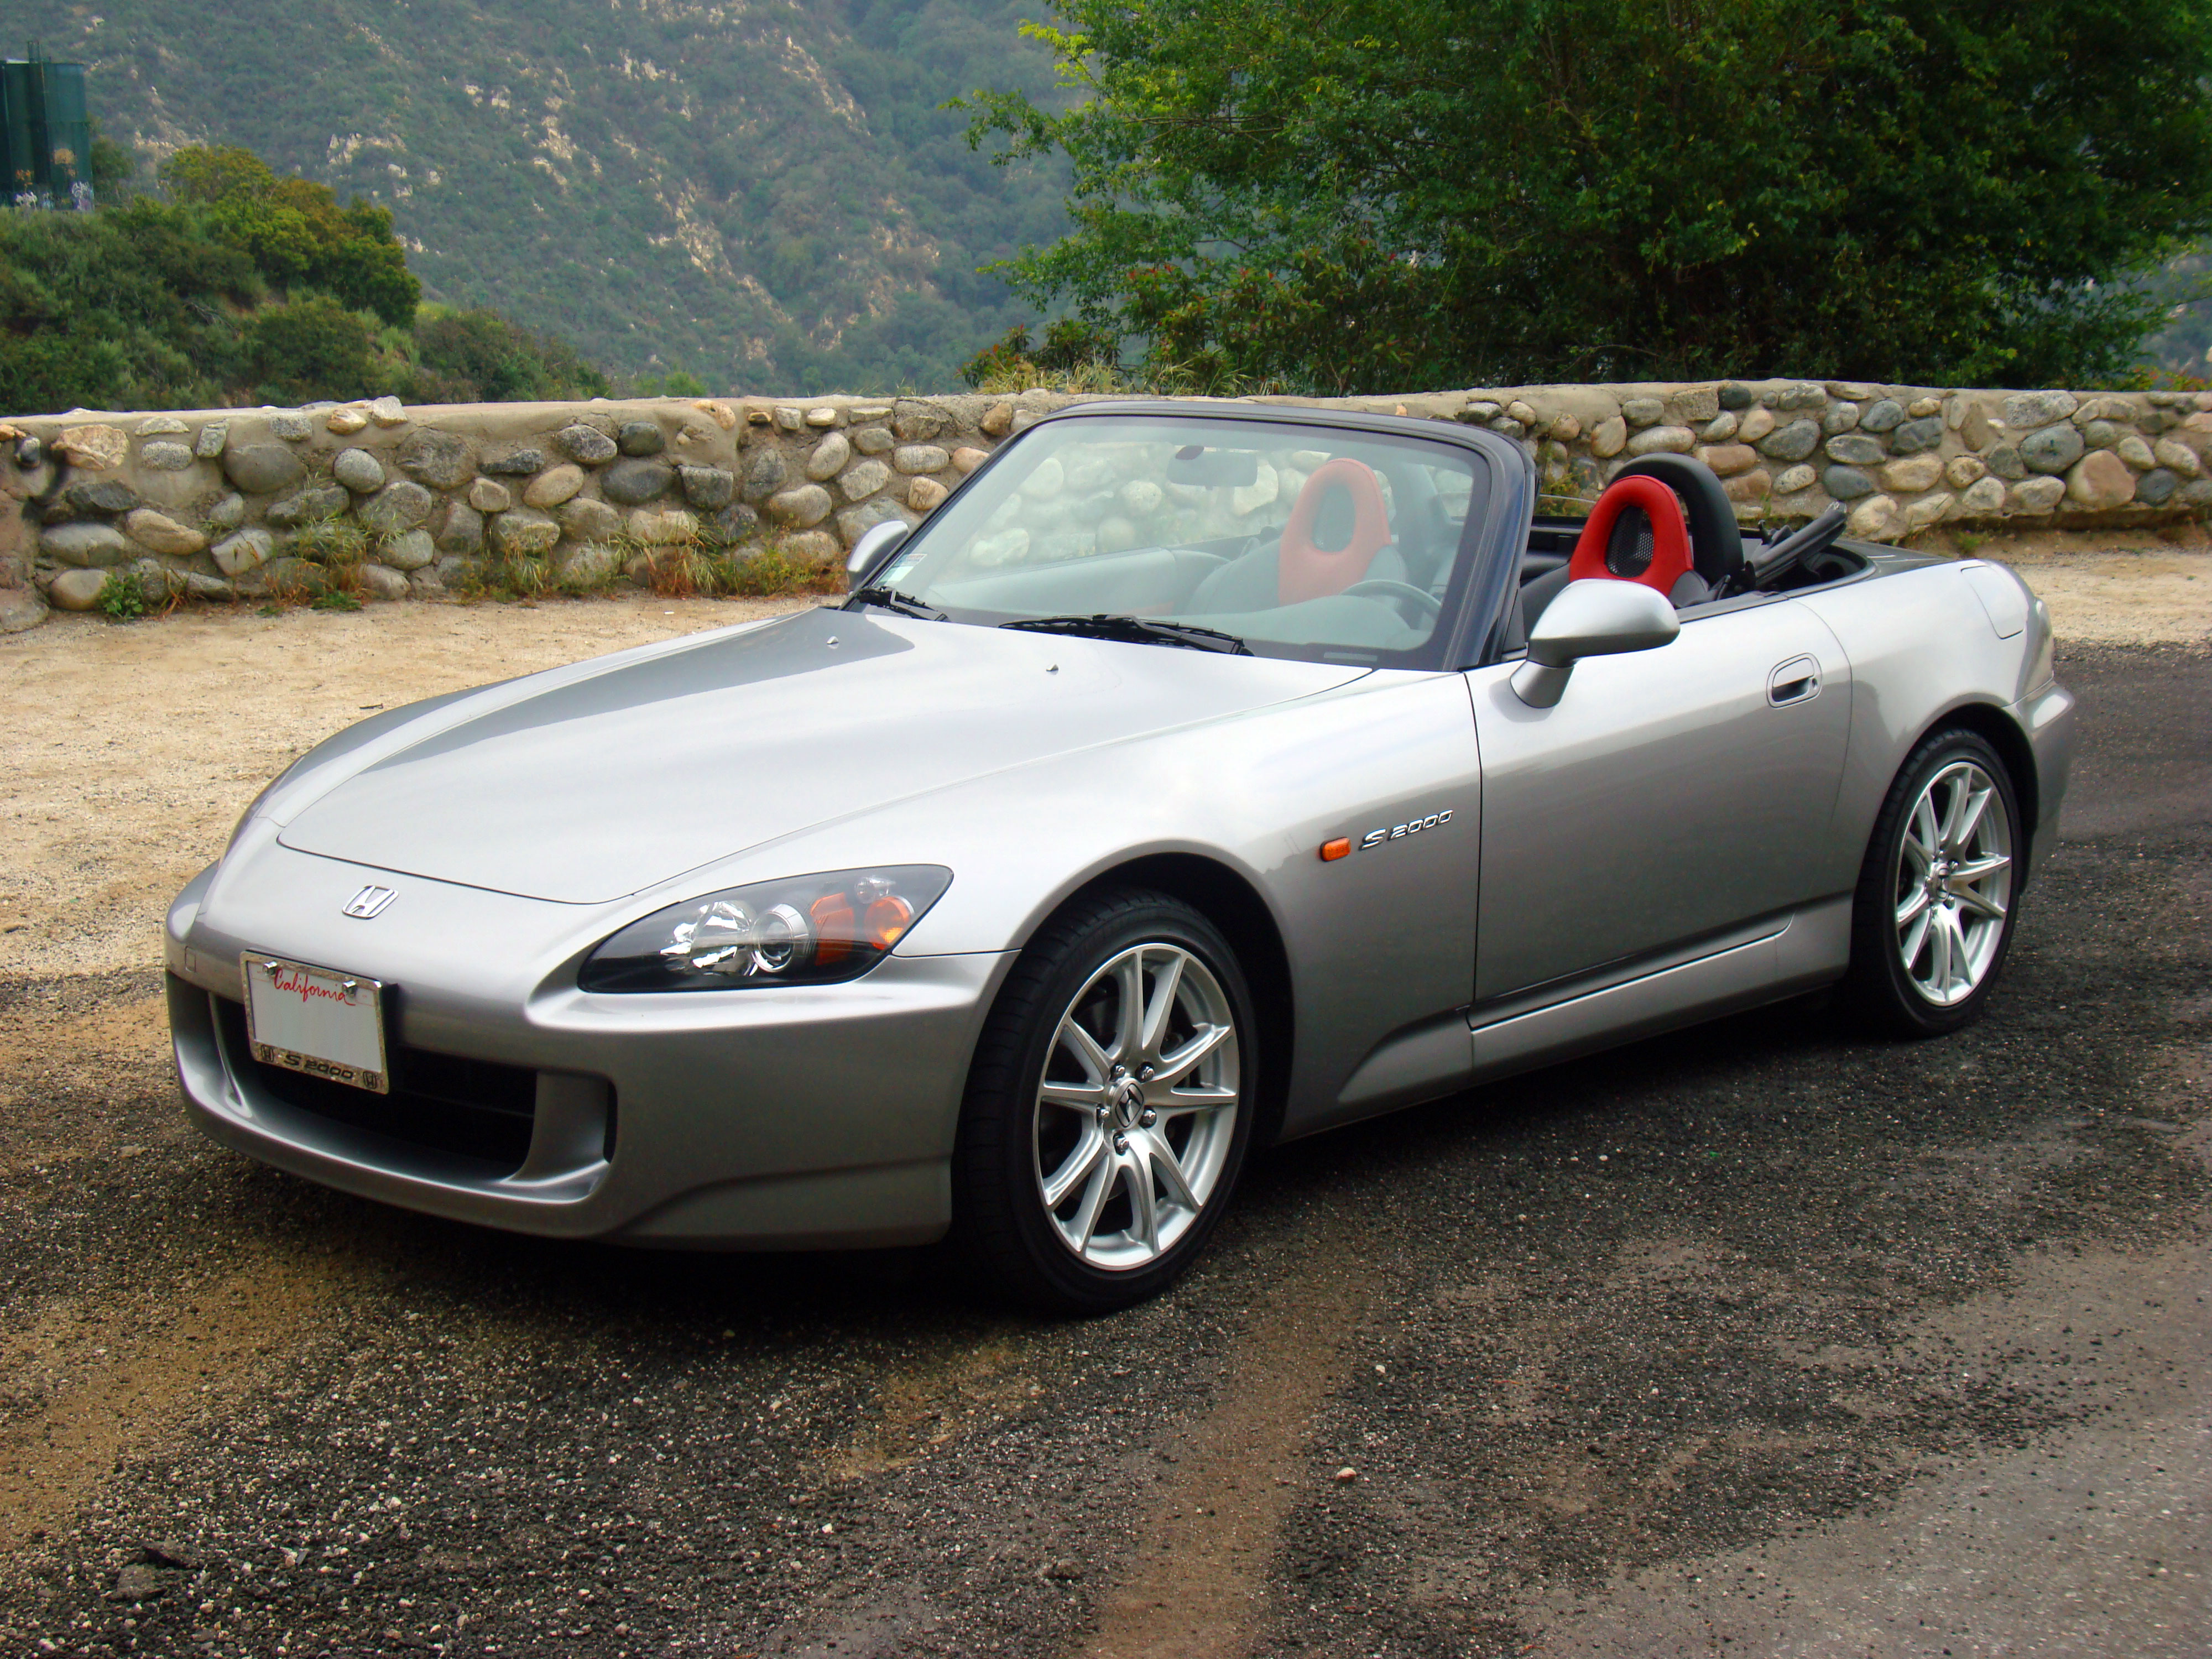


And the Porsche 911: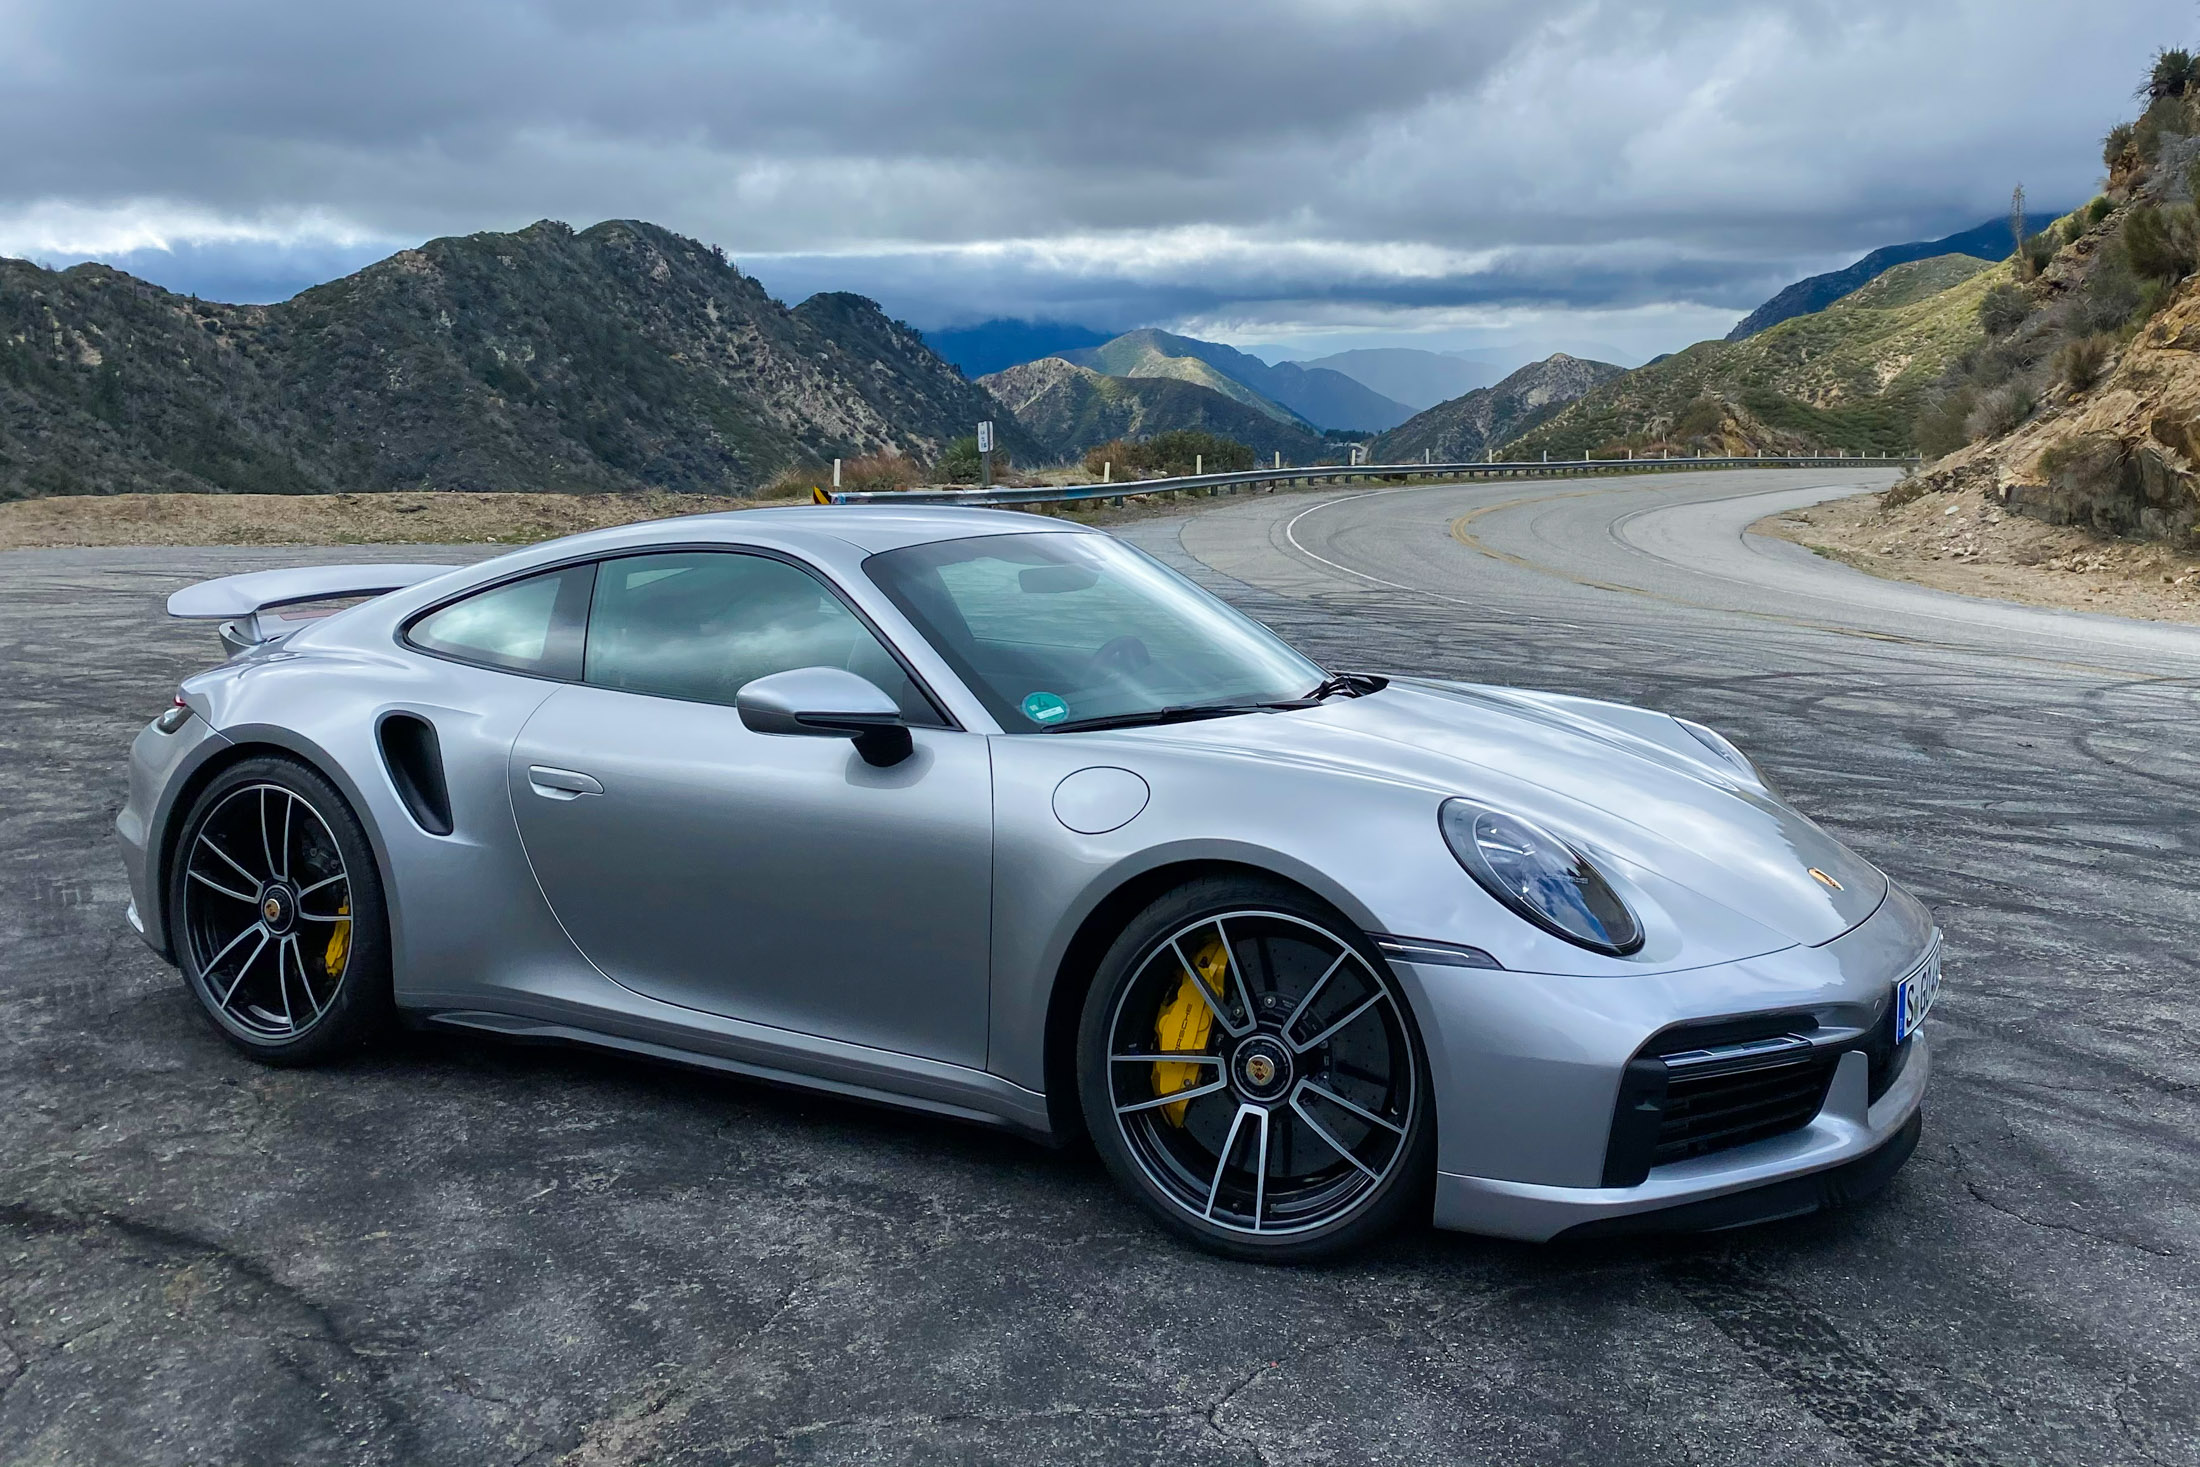

As said earlier, the more training data, the better the model. Having fewer images tends to result in overfitting, where the model is very good at sorting the images it was trained on, but much worse on new data. Luckily, we can massivly increase the amount of training data we train the model on by manipulating the images In the way described [here](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) by using the Keras package's ImageDataGenerator method on the data as its being used to test and validate the data. What this gives us is many variations of each image where the zoom, rotation, colour and other image properties are augmented randomly. So, using this process, our 1000 training images easily becimes 10000 training images with very little work. 

To find the images I can use google image searches of the car and then use a chrome extension such as [this one](https://chrome.google.com/webstore/detail/image-downloader/cnpniohnfphhjihaiiggeabnkjhpaldj) to download them as a batch. Afterwards, I can manually scan through the photos to remove ones I do not want to train the neural network on. This is one of the most manually intensive part of the process but is worth it in the end as the neural network can only be as good as the data it was trained on.

Before I start importing the data into python, I need to import some packages into python:

In [3]:
import numpy as np
# This is a basic mathematical package
import tensorflow as tf
# This is our main machine learning package
from tensorflow import keras
# This is a high-level machine learning package within tensorflow
import os
# This allows us to manipulate the working directory from within the notebook
import matplotlib.pyplot as plt
# And this is a powerful graphing package
%matplotlib inline
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

And I want to check my GPU is recognised so it can be used to compute the machine learning algorithms as a GPU is much better handled for this kind of task than a CPU

In [4]:
GPU = [[x.physical_device_desc for x in tf.python.client.device_lib.list_local_devices() if x.device_type == 'GPU'], tf.config.experimental.list_physical_devices('GPU')]
print("Num GPUs Available: ", len(GPU[1]), "\n\n", GPU[0])

Num GPUs Available:  1 

 ['device: 0, name: GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5']


And we want to make sure that tensorflow is allowing GPU memory growth

In [5]:
tf.config.experimental.set_memory_growth(GPU[1][0], True)

Before I start importing image files, I need to make sure the current working directory is the folder above where the image files are

In [4]:
os.getcwd()

'C:\\Users\\jacke\\data\\Cars'

After downloading the images, I put them into a directory called "car_images", and each image is sorted into one of three subdirectories: "porsche", "honda" or "null". My three sets of data are in the folders "honda", "porsche" and "null". Before I do anything to the images, I want to delete any duplicate photographs in each of these directories using some clever python code found in [this github depository](https://github.com/UrviSoni/remove_duplicate_image/blob/master/duplicate_image_remove.ipynb).

## Removing Duplicate Images Using Hashing by UrviSoni

I need to make sure I repeat this code once for each directory

In [5]:
os.chdir("car_images/porsche")
# os.chdir("../honda")
# os.chdir("../null")

In [6]:
os.getcwd()

'C:\\Users\\jacke\\data\\Cars\\car_images\\porsche'

In [7]:
import hashlib
from scipy.misc import imread, imresize, imshow
import matplotlib.gridspec as gridspec
import time

In [8]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

I can see how many images there are in the directory before the duplicates are removed

In [9]:
file_list = os.listdir()
print(len(file_list))

109


In [ ]:
import hashlib, os
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('.')):  #listdir('.') = current directory
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys: 
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))

And then print a list of the indices of each duplicate image

In [ ]:
duplicates

Use pyplot to display the duplicates

In [ ]:
for file_indexes in duplicates[:30]:
    try:
    
        plt.subplot(121),plt.imshow(imread(file_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(file_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

In [ ]:
for index in duplicates:
    os.remove(file_list[index[0]])

And finally, delete the duplicate images, and print the new number of images in the directory to make sure the duplicates have been removed

In [ ]:
file_list = os.listdir()
print(len(file_list))

Using this code, 12 duplicates were removed from the honda directory

Now that we have all our images, we are ready to manipulate the images for use in training a neural network. This image manipulation step requires some further packages to be imported.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import glob
import shutil

In [11]:
os.getcwd()

'C:\\Users\\jacke\\data\\Cars\\car_images\\porsche'

The first thing we need to do is create our train, validate and train directories before randomly assigning the images into these directories.

In [ ]:
if os.path.isdir('train/porsche') is False:
# if statement needed so that rerunning this cell does not overwrite data
    os.makedirs('train/honda')
    os.makedirs('train/null')
    os.makedirs('train/porsche')
    os.makedirs('valid/honda')
    os.makedirs('valid/null')
    os.makedirs('valid/porsche')
    os.makedirs('test/honda')
    os.makedirs('test/null')
    os.makedirs('test/porsche')

# Picks at random 700 porsche images and puts them in the train/porsche directory    
    for c in random.sample(glob.glob('car_images/porsche/*'), 700):
        shutil.move(c, 'train/porsche')
    for c in random.sample(glob.glob('car_images/honda/*'), 700):
        shutil.move(c, 'train/honda')
    for c in random.sample(glob.glob('car_images/null/*'), 1400):
        shutil.move(c, 'train/null')
    for c in random.sample(glob.glob('car_images/porsche/*'), 150):
        shutil.move(c, 'valid/porsche')
    for c in random.sample(glob.glob('car_images/honda/*'), 150):
        shutil.move(c, 'valid/honda')
    for c in random.sample(glob.glob('car_images/null/*'), 300):
        shutil.move(c, 'valid/null')
    for c in random.sample(glob.glob('car_images/porsche/*'), 150):
        shutil.move(c, 'test/porsche')
    for c in random.sample(glob.glob('car_images/honda/*'), 150):
        shutil.move(c, 'test/honda')
    for c in random.sample(glob.glob('car_images/null/*'), 300):
        shutil.move(c, 'test/null')

In [15]:
os.chdir("..")

Now we can assign these directories to an image data generator which will preprocess the data for use in a neural network

In [64]:
train_images = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True, rotation_range=25, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory='train', target_size=(224,224), classes=['porsche', 'honda', 'null'], batch_size=100)
valid_images = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True, rotation_range=25, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory='valid', target_size=(224,224), classes=['porsche', 'honda', 'null'], batch_size=100)
test_images = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, horizontal_flip=True, rotation_range=25, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(directory='test', target_size=(224,224), classes=['porsche', 'honda', 'null'], batch_size=100, shuffle=False)

Found 2800 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


When creating the datasets from the images, we can apply the data augmentation steps to increase the range of our data. We have used the mobilenet v2 preprocessing function to process the data as this is the neural network architecture I intend to use in order to build the machine learning model.

Now that the datasets have been defined, we can download the neural network architecture we intend to use. Using a pretrained model vastly improves our model accuracy. We also need to import a couple of packages to allow us to modify the neural network.

In [22]:
mobile = tf.keras.applications.MobileNetV2()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [18]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
x = mobile.layers[-1].output
output = Dense(units=3, activation='softmax')(x)

In [20]:
model = Model(inputs=mobile.input, outputs=output)

In [21]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [65]:
for layer in model.layers[:-2]:
    layer.trainable = False

NameError: name 'model' is not defined

In [23]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [24]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.fit(x=train_images, validation_data=valid_images, epochs=10, verbose=2)

Epoch 1/10


c:\users\jacke\anaconda3\envs\tensorflow\lib\site-packages\PIL\Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/56 - 88s - loss: 1.0536 - accuracy: 0.5014 - val_loss: 1.0256 - val_accuracy: 0.5000
Epoch 2/10
56/56 - 83s - loss: 1.0002 - accuracy: 0.5175 - val_loss: 0.9799 - val_accuracy: 0.5133
Epoch 3/10
56/56 - 81s - loss: 0.9601 - accuracy: 0.5800 - val_loss: 0.9449 - val_accuracy: 0.6183
Epoch 4/10
56/56 - 83s - loss: 0.9200 - accuracy: 0.6164 - val_loss: 0.9050 - val_accuracy: 0.6150
Epoch 5/10
56/56 - 82s - loss: 0.8874 - accuracy: 0.6350 - val_loss: 0.8729 - val_accuracy: 0.6433
Epoch 6/10
56/56 - 88s - loss: 0.8556 - accuracy: 0.6446 - val_loss: 0.8361 - val_accuracy: 0.6767
Epoch 7/10
56/56 - 86s - loss: 0.8218 - accuracy: 0.6993 - val_loss: 0.8148 - val_accuracy: 0.7283
Epoch 8/10
56/56 - 85s - loss: 0.7906 - accuracy: 0.7411 - val_loss: 0.7941 - val_accuracy: 0.7433
Epoch 9/10
56/56 - 84s - loss: 0.7603 - accuracy: 0.7686 - val_loss: 0.7644 - val_accuracy: 0.7600
Epoch 10/10
56/56 - 81s - loss: 0.7356 - accuracy: 0.7775 - val_loss: 0.7461 - val_accuracy: 0.7517


So the first attempt at training the neural network, ended with a predictive accuracy of just over 75% on the validation set. Lets see how well it can predict the categories of the test set.

In [26]:
predictions = model.predict(x=test_images, verbose=0)

In [27]:
true_classes = test_images.classes
class_labels = list(test_images.class_indices.keys())

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [39]:
cm = confusion_matrix(y_true=true_classes, y_pred=np.argmax(predictions, axis=-1))

In [60]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

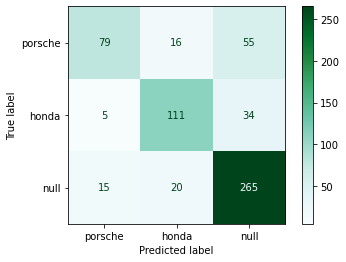

In [64]:
disp = disp.plot(cmap='BuGn')

Here we can see that the model has fared pretty succesfully on the test set, with limited overfitting. Its accuracy is still above 75% which is great for a first try. I will now be saving this model.

In [66]:
model.save('model_75.h5')

Lets try reimporting the model and increasing the number of trainable parameters

In [62]:
model2 = keras.models.load_model('model_75.h5')

In [63]:
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [67]:
for layer in model2.layers[:-21]:
    layer.trainable = False

In [53]:
from tensorflow.keras import regularizers
x = model2.layers[-2].output
output = Dense(units=3, activation='softmax', kernel_regularizer='l1')(x)

In [54]:
model2 = Model(inputs=model2.input, outputs=output)

In [68]:
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [69]:
model2.compile(optimizer=tf.keras.optimizers.RMSprop(), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [70]:
model2.fit(x=train_images, validation_data=valid_images, epochs=30, verbose=2)

Epoch 1/30
28/28 - 94s - loss: 0.8249 - accuracy: 0.6725 - val_loss: 0.8046 - val_accuracy: 0.7100
Epoch 2/30
28/28 - 91s - loss: 0.7102 - accuracy: 0.7764 - val_loss: 0.9472 - val_accuracy: 0.5467
Epoch 3/30
28/28 - 92s - loss: 0.6733 - accuracy: 0.7993 - val_loss: 1.0701 - val_accuracy: 0.5617
Epoch 4/30
28/28 - 93s - loss: 0.6387 - accuracy: 0.8171 - val_loss: 1.0406 - val_accuracy: 0.5950
Epoch 5/30
28/28 - 100s - loss: 0.5965 - accuracy: 0.8546 - val_loss: 1.1914 - val_accuracy: 0.5067
Epoch 6/30
28/28 - 98s - loss: 0.5841 - accuracy: 0.8529 - val_loss: 1.1957 - val_accuracy: 0.5117
Epoch 7/30
28/28 - 105s - loss: 0.5493 - accuracy: 0.8789 - val_loss: 1.2104 - val_accuracy: 0.5083
Epoch 8/30
28/28 - 104s - loss: 0.5273 - accuracy: 0.8868 - val_loss: 1.2380 - val_accuracy: 0.5000
Epoch 9/30
28/28 - 94s - loss: 0.5116 - accuracy: 0.8911 - val_loss: 1.2418 - val_accuracy: 0.5033
Epoch 10/30
28/28 - 106s - loss: 0.4877 - accuracy: 0.8961 - val_loss: 1.2580 - val_accuracy: 0.5017
Epoch

In [71]:
predictions2 = model2.predict(x=test_images, verbose=0)

In [72]:
cm = confusion_matrix(y_true=true_classes, y_pred=np.argmax(predictions2, axis=-1))

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

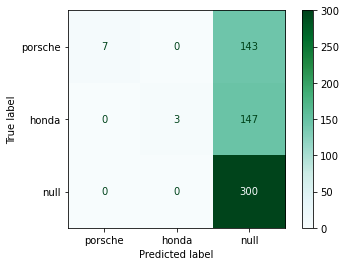

In [74]:
disp = disp.plot(cmap='BuGn')